## Where do embeddings come from?
### Embedding MNIST images and NLP sentences into vectors.


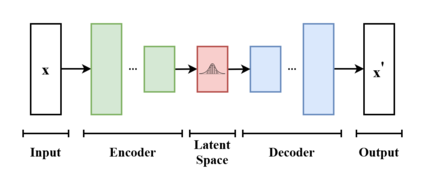

[Source](https://en.wikipedia.org/wiki/Variational_autoencoder)

# Requirements
### python 3.9.21
### tensorflow 2.14.0
### numpy 1.24.3
### sentence transfomers

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from scipy.stats import norm

In [2]:
# Load data – training and test
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()

In [3]:
#Normalize and Reshape images (flatten)
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr_flat, x_te_flat = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)

In [4]:
print(x_tr.shape, x_te.shape)
print(x_tr_flat.shape, x_te_flat.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 784) (10000, 784)


In [5]:
# Neural Network Parameters
batch_size, n_epoch = 100, 50
n_hidden, z_dim = 256, 2

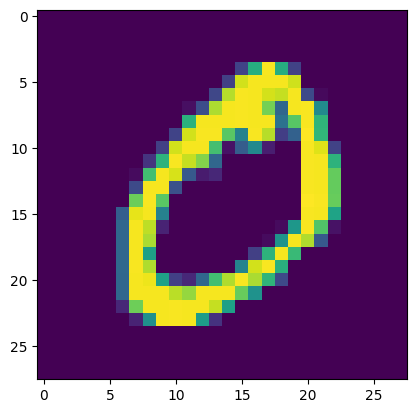

In [6]:
# Example of a training image
plt.imshow(x_tr[1]);


This function implements a sampling operation used in Variational Autoencoders (VAEs) for generating latent vectors from the learned mean and variance parameters of a latent distribution. Here's a breakdown of what the function does:

### Input
The function accepts a single argument, `args`, which is a tuple:
- `mu`: The mean of the latent space distribution (learned by the encoder network).
- `log_var`: The logarithm of the variance of the latent space distribution (also learned by the encoder network).

### Core Logic
1. **Generate Random Noise**:
   ```python
   eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
   ```
   - A random noise vector `eps` is drawn from a standard normal distribution (mean = 0, stddev = 1).
   - `shape=(batch_size, z_dim)` specifies that this noise has dimensions corresponding to the batch size and the latent space dimensionality (`z_dim`).

2. **Reparameterization Trick**:
   ```python
   mu + K.exp(log_var) * eps
   ```
   - The function reparameterizes the latent space distribution by combining `mu` (mean), `log_var` (logarithm of the variance), and `eps` (random noise).
   - `K.exp(log_var)` computes the standard deviation from the log variance.
   - The output is `mu + stddev * eps`, which ensures the output latent vector is sampled from a Gaussian distribution defined by the parameters `mu` and `log_var`.

### Purpose
The purpose of this function is to implement the **reparameterization trick**, which allows gradient-based optimization (backpropagation) during training. Without this trick, sampling directly from a probability distribution would not be differentiable.

### Output
The function returns a sampled latent vector, which has the same shape as `mu` and `log_var` and can be used in the decoder network of a Variational Autoencoder.

---

### Context
This function is commonly used in the encoding step of a Variational Autoencoder (VAE), where:
- The encoder outputs `mu` and `log_var` for the latent space.
- The decoder takes the sampled latent vector to generate reconstructed data.

In [7]:
# sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps

This code snippet defines the **encoder** part of a Variational Autoencoder (VAE) model. Here's a detailed explanation with comments for each line:

---

### Code Explanation with Comments

```python
# Encoder - from 784->256->128->2
```
- This comment describes the architecture of the encoder, which takes an input of size **784** (e.g., flattened MNIST images, each 28x28 pixels), reduces it to **256**, then to **128**, and finally to a **latent space** of size 2 (specified by `z_dim`).

```python
inputs_flat = Input(shape=(x_tr_flat.shape[1:]))
```
- **`Input`**: Defines the input layer for the encoder. The shape of the input is determined by the number of features in the training data `x_tr_flat` (e.g., 784 for flattened MNIST images).

```python
x_flat = Dense(n_hidden, activation='relu')(inputs_flat) # first hidden layer
```
- **First hidden layer**: Applies a fully connected layer (`Dense`) with `n_hidden` neurons (e.g., 256) and the ReLU activation function. This learns a representation of the input data.
  
```python
x_flat = Dense(n_hidden//2, activation='relu')(x_flat)  # second hidden layer
```
- **Second hidden layer**: Another fully connected layer, this time with half as many neurons (`n_hidden//2`, e.g., 128). This progressively reduces the dimensionality of the learned representation.

```python
mu_flat = Dense(z_dim)(x_flat)
log_var_flat = Dense(z_dim)(x_flat)
```
- **Latent space parameters**:
  - `mu_flat`: Outputs the mean (`mu`) of the latent space distribution, with size equal to `z_dim` (e.g., 2).
  - `log_var_flat`: Outputs the logarithm of the variance (`log_var`) of the latent space distribution, also of size `z_dim`.
  - Both are learned parameters produced by two separate dense layers.

```python
z_flat = Lambda(sampling, output_shape=(z_dim,))([mu_flat, log_var_flat])
```
- **Sampling latent vector**:
  - `Lambda`: Wraps the custom sampling function (defined earlier) to perform the reparameterization trick.
  - The function takes the mean (`mu_flat`) and log variance (`log_var_flat`) to sample a vector `z_flat` from the latent space.
  - The sampled vector `z_flat` has the same dimensionality as the latent space (`z_dim`, e.g., 2).

---

### High-Level Summary
- The encoder starts with an input layer for flattened data (e.g., images).
- Two dense layers reduce the input dimensions while learning a compressed representation of the data.
- The encoder computes two outputs: the **mean** (`mu_flat`) and **log variance** (`log_var_flat`) of the latent space distribution.
- Using the reparameterization trick (`sampling` function), it generates a latent vector (`z_flat`) for the decoder.

### Usage
This encoder is typically combined with a decoder (which reconstructs data from the latent vector) and trained to minimize a loss function that combines:
1. **Reconstruction loss** (e.g., mean squared error or binary cross-entropy).
2. **KL divergence loss** (to ensure the latent space approximates a normal distribution).

In [8]:
# Encoder - from 784->256->128->2
inputs_flat = Input(shape=(x_tr_flat.shape[1:]))
x_flat = Dense(n_hidden, activation='relu')(inputs_flat) # first hidden layer
x_flat = Dense(n_hidden//2, activation='relu')(x_flat)  # second hidden layer

# hidden state, which we will pass into the Model to get the Encoder.
mu_flat = Dense(z_dim)(x_flat)
log_var_flat = Dense(z_dim)(x_flat)
z_flat = Lambda(sampling, output_shape=(z_dim,))([mu_flat, log_var_flat])

The following cell defines the **decoder** part of a Variational Autoencoder (VAE) model, which reconstructs data from the latent space representation.

---

### Code Explanation with Comments

```python
# Decoder - from 2->128->256->784
```
- This comment describes the architecture of the decoder, which takes a **latent vector** of size 2 (specified by `z_dim`), expands it to **128**, then to **256**, and finally reconstructs the original data size **784** (e.g., flattened 28x28 MNIST images).

```python
latent_inputs = Input(shape=(z_dim,))
```
- **Input layer for the latent space**:
  - Defines the input to the decoder, which is the sampled latent vector of size `z_dim` (e.g., 2).
  - This input represents a point in the latent space.

```python
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr_flat.shape[1], activation='sigmoid')
```
- **Dense layers for the decoder**:
  - `z_decoder1`: A dense layer with `n_hidden//2` neurons (e.g., 128) and ReLU activation, starting to expand the latent vector.
  - `z_decoder2`: A dense layer with `n_hidden` neurons (e.g., 256) and ReLU activation, continuing the expansion process.
  - `y_decoder`: A dense layer with output size equal to the original input data's dimension (`x_tr_flat.shape[1]`, e.g., 784). Uses a sigmoid activation function for producing values between 0 and 1 (common for image data).

```python
z_decoded = z_decoder1(latent_inputs)
```
- **First decoding layer**:
  - Passes the latent vector (`latent_inputs`) through the first dense layer (`z_decoder1`) to expand it to `n_hidden//2` dimensions (e.g., 128).

```python
z_decoded = z_decoder2(z_decoded)
```
- **Second decoding layer**:
  - Passes the output of the first decoding layer into the second dense layer (`z_decoder2`), further expanding it to `n_hidden` dimensions (e.g., 256).

```python
y_decoded = y_decoder(z_decoded)
```
- **Output reconstruction layer**:
  - Passes the output of the second decoding layer into the final dense layer (`y_decoder`) to reconstruct the input data size (e.g., 784 for flattened MNIST images).
  - The `sigmoid` activation ensures output values are scaled between 0 and 1, suitable for reconstructing normalized image data.

```python
decoder_flat = Model(latent_inputs, y_decoded, name="decoder_conv")
```
- **Define the decoder model**:
  - Creates a `Model` using the input (`latent_inputs`) and output (`y_decoded`) of the decoder.
  - The `name="decoder_conv"` assigns a name to the model for easy identification.

```python
outputs_flat = decoder_flat(z_flat)
```
- **Apply the decoder to the latent vector**:
  - Takes the sampled latent vector (`z_flat`) from the encoder and passes it through the decoder model (`decoder_flat`).
  - The output (`outputs_flat`) is the reconstructed version of the original input data.

---

### High-Level Summary
- **Decoder Functionality**:
  - Starts with a latent vector sampled from the latent space.
  - Expands the vector through progressively larger dense layers.
  - Reconstructs the original input data dimensions using a sigmoid activation for the output.

- **Purpose**:
  - The decoder learns to map latent space vectors back to the original data distribution during training.
  - Combined with the encoder, this enables the VAE to compress and reconstruct data effectively.

---

### Training
During training:
1. The VAE minimizes a **reconstruction loss** (e.g., binary cross-entropy for normalized image data) to ensure the output matches the input.
2. The **KL divergence loss** ensures the latent space approximates a normal distribution.

In [9]:
#Decoder - from 2->128->256->784
latent_inputs = Input(shape=(z_dim,))
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr_flat.shape[1], activation='sigmoid')
z_decoded = z_decoder1(latent_inputs)
z_decoded = z_decoder2(z_decoded)
y_decoded = y_decoder(z_decoded)
decoder_flat = Model(latent_inputs, y_decoded, name="decoder_conv")

outputs_flat = decoder_flat(z_flat)

In [10]:
# variational autoencoder (VAE) - to reconstruction input
reconstruction_loss = losses.binary_crossentropy(inputs_flat,
                                                 outputs_flat) * x_tr_flat.shape[1]
kl_loss = 0.5 * K.sum(K.square(mu_flat) + K.exp(log_var_flat) - log_var_flat - 1, axis = -1)
vae_flat_loss = reconstruction_loss + kl_loss

# Build model
#  Ensure that the reconstructed outputs are as close to the inputs
vae_flat = Model(inputs_flat, outputs_flat)
vae_flat.add_loss(vae_flat_loss)
vae_flat.compile(optimizer='adam')

In [11]:
# train
vae_flat.fit(
    x_tr_flat,
    shuffle=True,
    epochs=n_epoch,
    batch_size=batch_size,
    validation_data=(x_te_flat, None),
    verbose=1
)

Epoch 1/50
600/600 [==============================] - 9s 12ms/step - loss: 197.1862 - val_loss: 171.9942
Epoch 2/50
600/600 [==============================] - 3s 5ms/step - loss: 167.5211 - val_loss: 162.7233
Epoch 3/50
600/600 [==============================] - 5s 8ms/step - loss: 160.9277 - val_loss: 158.8031
Epoch 4/50
600/600 [==============================] - 10s 17ms/step - loss: 157.0868 - val_loss: 155.4859
Epoch 5/50
600/600 [==============================] - 12s 20ms/step - loss: 154.1503 - val_loss: 152.8609
Epoch 6/50
600/600 [==============================] - 9s 15ms/step - loss: 151.7962 - val_loss: 151.0823
Epoch 7/50
600/600 [==============================] - 9s 15ms/step - loss: 149.9070 - val_loss: 149.2525
Epoch 8/50
600/600 [==============================] - 7s 11ms/step - loss: 148.2074 - val_loss: 147.9159
Epoch 9/50
600/600 [==============================] - 7s 11ms/step - loss: 146.8374 - val_loss: 146.5416
Epoch 10/50
600/600 [==============================] - 

### Visualize Embeddings

In [12]:
# Build encoders
encoder_f = Model(inputs_flat, z_flat)  # flat encoder

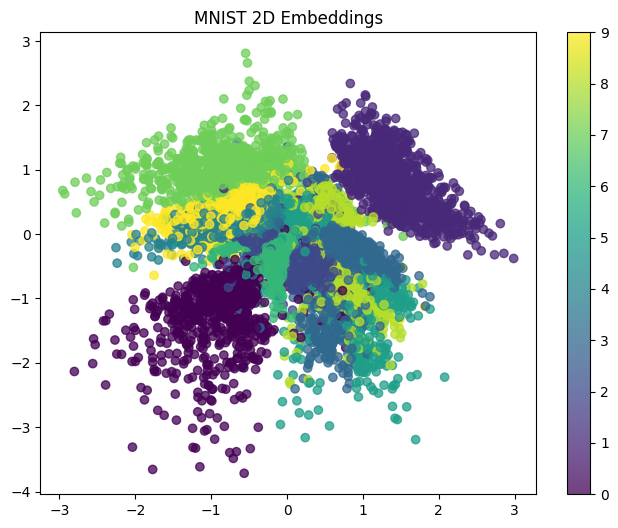

In [13]:
# Plot of the digit classes in the latent space
x_te_latent = encoder_f.predict(x_te_flat, batch_size=batch_size,verbose=0)
plt.figure(figsize=(8, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te, alpha=0.75)
plt.title('MNIST 2D Embeddings')
plt.colorbar()
plt.show()

## Example: compare three embeddings

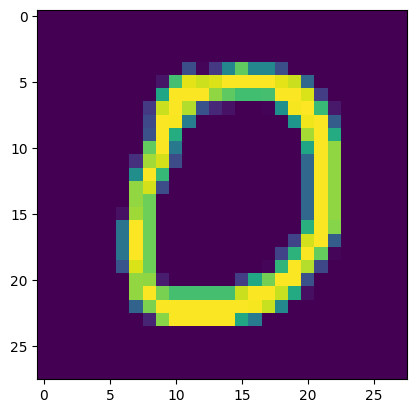

In [14]:
plt.imshow(x_te_flat[10].reshape(28,28));

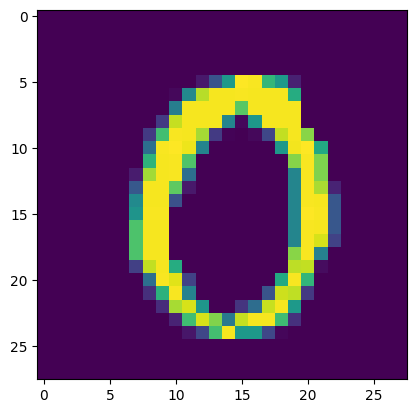

In [15]:
plt.imshow(x_te_flat[13].reshape(28,28));

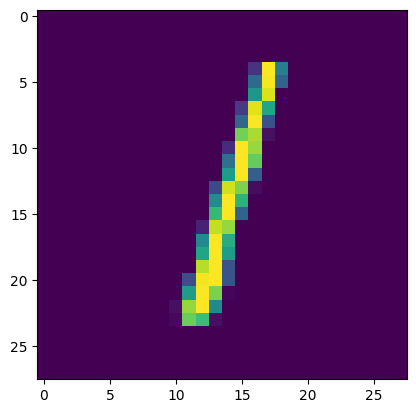

In [16]:
plt.imshow(x_te_flat[2].reshape(28,28));

In [17]:
# calculate vectors for each digit
zero_A = x_te_latent[10]
zero_B = x_te_latent[13]
one = x_te_latent[2]

print(f"Embedding for the first ZERO is  {zero_A}")
print(f"Embedding for the second ZERO is {zero_B}")
print(f"Embedding for the ONE is         {one}")

Embedding for the first ZERO is  [-0.7946422 -1.257736 ]
Embedding for the second ZERO is [-0.5623156 -1.0099914]
Embedding for the ONE is         [1.6745594 0.8055051]


## Using more advanced models based on the Transformer architechture you can embed sentences aswell.

In [19]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [20]:
#Sentences we want to encode. Example:
sentence = ['The team enjoyed the hike through the meadow',
            'The national park had great views',
            'Olive oil drizzled over pizza tastes delicious']

In [21]:
#Sentences are encoded by calling model.encode()
embedding = model.encode(sentence)

#Preview the embeddings
print(embedding)

[[ 0.37061968  0.26414266  0.21265665 ...  0.14994559 -0.2579493
  -0.23970751]
 [ 0.6693332   0.40094957 -0.48208398 ...  0.10645877 -1.506716
  -0.01547347]
 [-0.2655591   0.11172403 -0.14733021 ...  0.4219747   0.8839462
   0.10763929]]


In [22]:
embedding.shape

(3, 384)

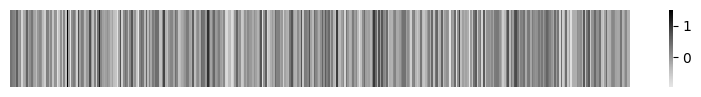

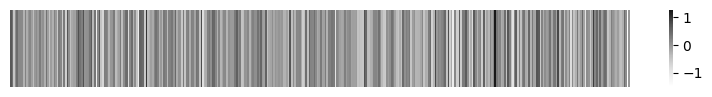

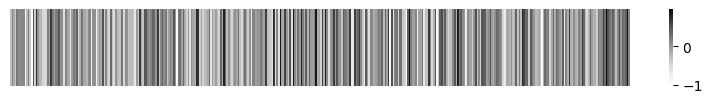

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(embedding[0].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embedding[1].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embedding[2].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

## How can we measure the distance between these Image and Sentence Embeddings?

There are many ways to calculate the distances between two vectors.

Here we will cover 4 distance metrics that you might find being used in the context of vector databases:
- Euclidean Distance(L2)
- Manhattan Distance(L1)
- Dot Product
- Cosine Distance

### Euclidean Distance(L2)
The length of the shortest path between two points or vectors.

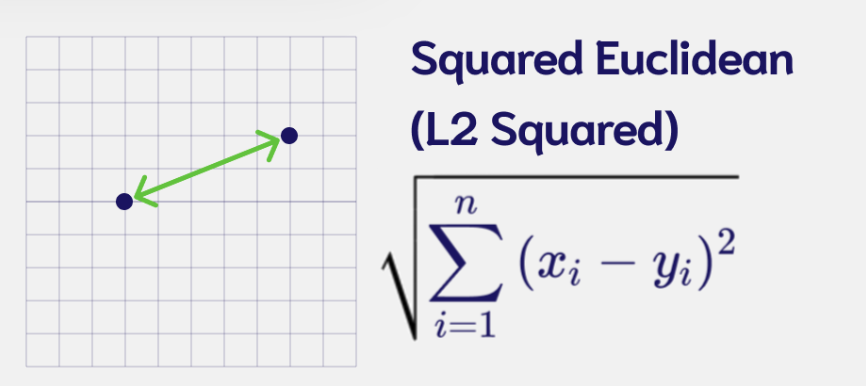

In [25]:
# Euclidean Distance
L2 = [(zero_A[i] - zero_B[i])**2 for i in range(len(zero_A))]
L2 = np.sqrt(np.array(L2).sum())
print(L2)

0.33963661263066725


In [26]:
#An alternative way of doing this
np.linalg.norm((zero_A - zero_B), ord=2)

0.33963662

In [27]:
#Calculate L2 distances
print("Distance zeroA-zeroB:", np.linalg.norm((zero_A - zero_B), ord=2))
print("Distance zeroA-one:  ", np.linalg.norm((zero_A - one), ord=2))
print("Distance zeroB-one:  ", np.linalg.norm((zero_B - one), ord=2))

Distance zeroA-zeroB: 0.33963662
Distance zeroA-one:   3.2177508
Distance zeroB-one:   2.8809092


### Manhattan Distance(L1)
Distance between two points if one was constrained to move only along one axis at a time.

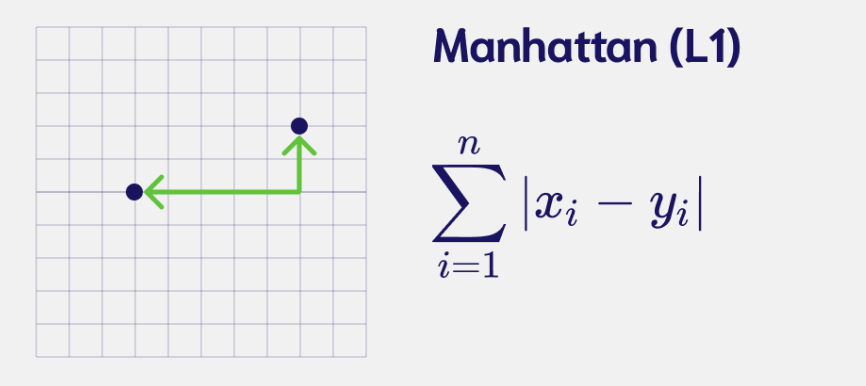

In [28]:
# Manhattan Distance
L1 = [zero_A[i] - zero_B[i] for i in range(len(zero_A))]
L1 = np.abs(L1).sum()

print(L1)

0.4800712


In [29]:
#an alternative way of doing this is
np.linalg.norm((zero_A - zero_B), ord=1)

0.4800712

In [30]:
#Calculate L1 distances
print("Distance zeroA-zeroB:", np.linalg.norm((zero_A - zero_B), ord=1))
print("Distance zeroA-one:  ", np.linalg.norm((zero_A - one), ord=1))
print("Distance zeroB-one:  ", np.linalg.norm((zero_B - one), ord=1))

Distance zeroA-zeroB: 0.4800712
Distance zeroA-one:   4.5324426
Distance zeroB-one:   4.0523715


### Dot Product
Measures the magnitude of the projection of one vector onto the other.

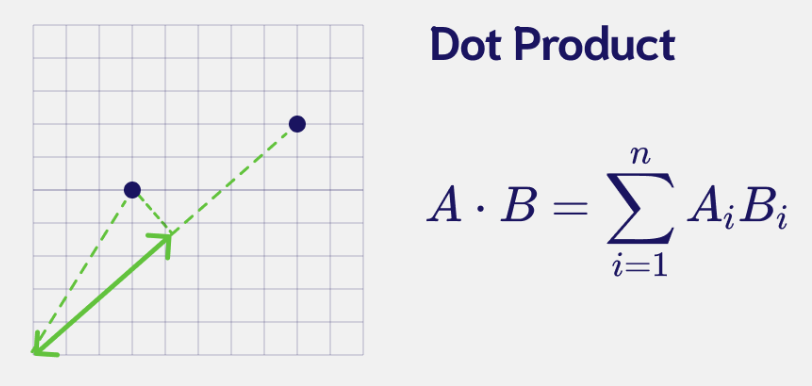

In [31]:
# Dot Product
np.dot(zero_A,zero_B)

1.7171422

In [32]:
#Calculate Dot products
print("Distance zeroA-zeroB:", np.dot(zero_A, zero_B))
print("Distance zeroA-one:  ", np.dot(zero_A, one))
print("Distance zeroB-one:  ", np.dot(zero_B, one))

Distance zeroA-zeroB: 1.7171422
Distance zeroA-one:   -2.3437884
Distance zeroB-one:   -1.755184


### Cosine Distance
Measure the difference in directionality between vectors.

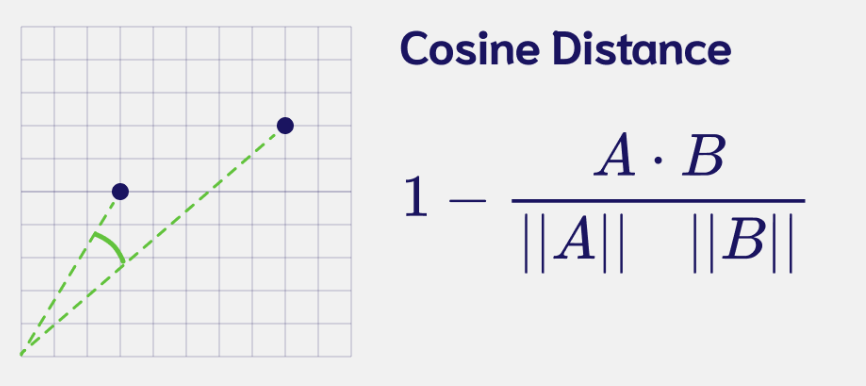

In [33]:
# Cosine Distance
cosine = 1 - np.dot(zero_A,zero_B)/(np.linalg.norm(zero_A)*np.linalg.norm(zero_B))
print(f"{cosine:.6f}")

0.001538


In [34]:
zero_A/zero_B

array([1.4131606, 1.2452937], dtype=float32)

In [35]:
# Cosine Distance function
def cosine_distance(vec1,vec2):
  cosine = 1 - (np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2)))
  return cosine

In [36]:
#Cosine Distance
print(f"Distance zeroA-zeroB: {cosine_distance(zero_A, zero_B): .6f}")
print(f"Distance zeroA-one:   {cosine_distance(zero_A, one): .6f}")
print(f"Distance zeroB-one:   {cosine_distance(zero_B, one): .6f}")

Distance zeroA-zeroB:  0.001538
Distance zeroA-one:    1.847804
Distance zeroB-one:    1.817102


## Now with the sentence embeddings!

Dot Product and Cosine Distance are commonly used in the field of NLP, to evaluate how similar two sentence embeddings are.
So here we will only use those two.

- embedding0 - 'The team enjoyed the hike through the meadow'

- embedding1 - The national park had great views'

- embedding2 - 'Olive oil drizzled over pizza tastes delicious'

In [37]:
#Dot Product
print("Distance 0-1:", np.dot(embedding[0], embedding[1]))
print("Distance 0-2:", np.dot(embedding[0], embedding[2]))
print("Distance 1-2:", np.dot(embedding[1], embedding[2]))

Distance 0-1: 26.497887
Distance 0-2: 2.0785775
Distance 1-2: 4.019213


In [38]:
#Cosine Distance
print("Distance 0-1: ", cosine_distance(embedding[0], embedding[1]))
print("Distance 0-2: ", cosine_distance(embedding[0], embedding[2]))
print("Distance 1-2: ", cosine_distance(embedding[1], embedding[2]))

Distance 0-1:  0.5350336134433746
Distance 0-2:  0.9639393128454685
Distance 1-2:  0.9288790673017502
